# Dual Digital Pricing methods

The purpose of this notebook is to review dual digital pricing / sensitivities and to introduce realized correlation skew

## Contents
   - [Numerical Integration](#sec1)
       - [Present Value](#sec2)
       - [Partial Derivatives](#sec3)
   - [Realized Parameters](#sec4)
       - [Realized Volatility Skew](#sec5)
       - [Realized Correlation Skew](#sec6)

In [14]:
import imp
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go

import module
imp.reload(module)
from module.backtest import Backtest
from module.pricing import DualDigital

# -----
# SET DISPLAY SETTINGS
# -----
pd.set_option('display.width', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

<a id='sec1'></a>
## Numerical Integration

<a id='sec2'></a>
### Present Value


The following formula describes how the present value of the product is calculated: $ PV = Probability * CashFlow * Discount $

Where $Discount = e^{-rt} $ and the $Probability$ comes from the integration of the bivariate log-normal distribution (joint probability density function) defined as below

\begin{aligned}
& f_{X, Y}(x, y)=\frac{1}{2 \pi \sigma_1 \sigma_2 \sqrt{1-\rho^2} x y} \exp \left\{-\frac{1}{2\left(1-\rho^2\right)}\left[\left(\frac{\log x-\mu_1}{\sigma_1}\right)^2+\left(\frac{\log y-\mu_2}{\sigma_2}\right)^2 -2 \rho\left(\frac{\log x-\mu_1}{\sigma_1}\right)\left(\frac{\log y-\mu_2}{\sigma_2}\right)\right]\right\}
\end{aligned}

<br>

For example, for a down down dual digital we have 
$$Probability = \int_{0}^{K_{x}}\int_{0}^{K_{Y}} f(x, y) dy dx $$


In [2]:
data = dict()
for st1 in tqdm(np.linspace(start=0.1, stop=2, num=40)):
    for st2 in np.linspace(start=0.1, stop=2, num=40):
        priceable = DualDigital(
            st1=st1, k1=1, iv1=0.2, q1=0, b1=0, direction1='down',
            st2=st2, k2=1, iv2=0.2, q2=0, b2=0, direction2='down',
            rho=0.8, r=0, t=1, unit=100, model='numerical_integration'
        )
        priceable.calculate_present_value()
        pv = priceable.get_present_value()
        data[(st1, st2)] = pv
data_df = pd.Series(data).unstack()

  0%|          | 0/40 [00:00<?, ?it/s]

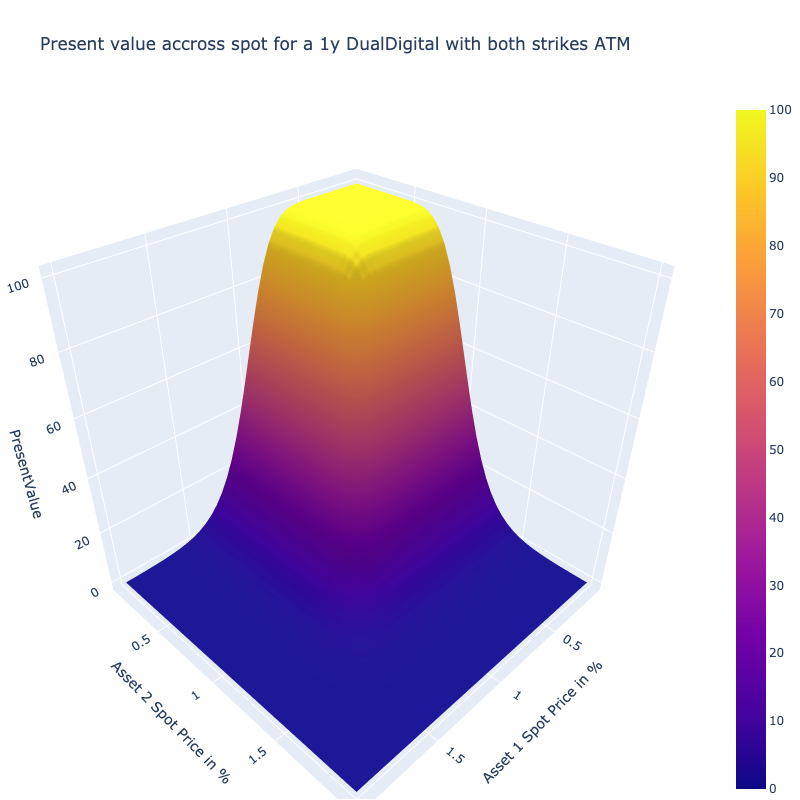

In [3]:
fig = go.Figure(data=[go.Surface(x=data_df.index, y=data_df.columns, z=data_df.values)])
fig.update_layout(
    title = "Present value accross spot for a 1y DualDigital with both strikes ATM",
    scene = dict(
        xaxis_title='Asset 1 Spot Price in %', 
        yaxis_title='Asset 2 Spot Price in %',
        zaxis_title='PresentValue'),
    width=800, height=800, margin=dict(r=1, b=1, l=1, t=100))

fig.show('png')

<a id='sec3'></a>
### Partial Derivatives

Delta, Gamma and X Gamma are computed numerically using the below formula

$$ \Delta_{x} = \frac{\partial f}{\partial x} = \lim _{\Delta \rightarrow 0} \frac{f\left(x+\Delta, y\right)-f\left(x, y\right)}{\Delta}$$ 

$$ \Delta_{y} = \frac{\partial f}{\partial y} = \lim _{\Delta \rightarrow 0} \frac{f\left(x, y+\Delta\right)-f\left(x, y\right)}{\Delta}$$ 


$$\Gamma_{x} = \frac{\partial}{\partial x}\frac{\partial f}{\partial x} = \lim _{\Delta \rightarrow 0} \frac{f\left(x+\Delta, y\right)-2f\left(x, y\right)+ f\left(x-\Delta, y\right)}{(\Delta)^{2}}$$

$$\Gamma_{y} = \frac{\partial}{\partial y}\frac{\partial f}{\partial y} = \lim _{\Delta \rightarrow 0} \frac{f\left(x, y+\Delta\right)-2f\left(x, y\right)+ f\left(x, y-\Delta\right)}{(\Delta)^{2}}$$


$$\Gamma_{xy} = \frac{\partial}{\partial x}\frac{\partial f}{\partial y} = \lim _{\Delta \rightarrow 0} \frac{f\left(x+\Delta, y+\Delta\right)-f\left(x+\Delta, y\right)- f\left(x, y+\Delta \right) + f\left(x, y\right)}{(\Delta)^{2}}$$

<br>

Using a second-order Taylor series, we can estimate the quadratic P&L approximation formula for Delta, Gamma and X Gamma

$$\Delta f \simeq f_{x}\left(x-x_{0}\right)+f_{y}\left(y-y_{0}\right)+\frac{1}{2} f_{x x}\left(x-x_{0}\right)^{2}+f_{x y}\left(x-x_{0}\right)\left(y-y_{0}\right)+\frac{1}{2} f_{y y}\left(y-y_{0}\right)^{2}$$

In [4]:
data = dict()
for st1 in tqdm(np.linspace(start=0.1, stop=2, num=20)):
    for st2 in np.linspace(start=0.1, stop=2, num=20):
        priceable = DualDigital(
            st1=st1, k1=1, iv1=0.2, q1=0, b1=0, direction1='down',
            st2=st2, k2=1, iv2=0.2, q2=0, b2=0, direction2='down',
            rho=0.8, r=0, t=1, unit=100, model='numerical_integration'
        )
        priceable.calculate_present_value()
        priceable.calculate_x_gamma()
        pv = priceable.get_present_value()
        greeks = priceable.get_greeks()
        data[(st1, st2)] = greeks.get('dst1*dst2')
data_df = pd.Series(data).unstack()

  0%|          | 0/20 [00:00<?, ?it/s]

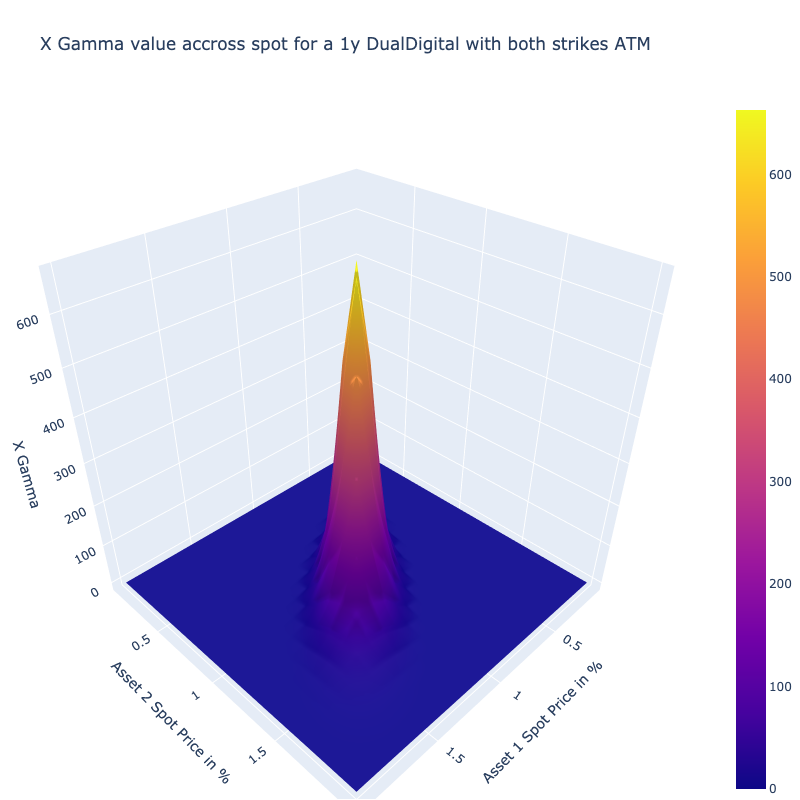

In [5]:
fig = go.Figure(data=[go.Surface(x=data_df.index, y=data_df.columns, z=data_df.values)])
fig.update_layout(
    title = "X Gamma value accross spot for a 1y DualDigital with both strikes ATM",
    scene = dict(
        xaxis_title='Asset 1 Spot Price in %', 
        yaxis_title='Asset 2 Spot Price in %',
        zaxis_title='X Gamma'),
    width=800, height=800, margin=dict(r=1, b=1, l=1, t=100))

fig.show('png')

In [6]:
data_df

,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2.00
0.10,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
0.20,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.30,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
0.40,0.00,0.00,0.00,0.03,0.07,0.01,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00
0.50,-0.00,0.00,0.00,0.07,2.71,4.26,1.07,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0.60,0.00,0.00,0.00,0.01,4.26,40.82,47.26,14.44,1.84,0.13,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00
0.70,0.00,-0.00,0.00,0.00,1.07,47.26,200.00,188.05,64.61,11.08,1.16,0.09,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
0.80,-0.00,-0.00,0.00,0.00,0.09,14.44,188.05,468.91,381.17,141.33,29.85,4.18,0.43,0.04,0.00,0.00,0.00,0.00,0.00,0.00
0.90,0.00,0.00,-0.00,0.00,0.00,1.84,64.61,381.17,662.83,485.50,189.86,46.67,8.10,1.08,0.12,0.01,0.00,0.00,0.00,0.00
1.00,0.00,-0.00,0.00,0.00,0.00,0.13,11.08,141.33,485.50,654.14,444.14,180.71,49.85,10.21,1.66,0.22,0.03,0.00,0.00,0.00


<a id='sec4'></a>
## Realized Parameters

<a id='sec5'></a>
### TODO ...